In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import load
from itertools import product
from glob import glob
import pandas as pd
import os
from matplotlib.backends.backend_pdf import PdfPages

from sys import path
path.append("../src")
from utils import save_pickle

In [2]:
stacking_strategies = ["igcngru_features", "idarkvec", "features"]
stacking_strategies.sort()
STRATS_POSFIX = '-'.join(stacking_strategies)

SCENARIOS = {
    1: {"DATA_SOURCES": ["darknet", "honeypot"]},
    2: {"DATA_SOURCES": ["darknet"]},
    3: {"DATA_SOURCES": ["honeypot"]},
    4: {"DATA_SOURCES": ["darknet"]},
    5: {"DATA_SOURCES": ["honeypot"]},
}

stacking_strategies.sort()
with_nodes = "vanilla-us"
target_day = "20221021"

probs_cols = [
    "censys",
    "driftnet",
    "internetcensus",
    "intrinsec",
    "ipip",
    "mirai",
    "onyphe",
    "rapid7",
    "securitytrails",
    "shadowserver",
    "shodan",
    "u_mich",
    "unk_bruteforcer",
    "unk_exploiter",
    "unk_spammer",
    "unknown",
]
probs_cols.sort()

In [3]:
strats_posfix = "-".join(sorted(stacking_strategies))

In [4]:
model = load(
    f"../data/2022/output/darknet-honeypot/{STRATS_POSFIX}/1/stacking_data/{target_day}/0/lr.joblib"
)

In [5]:
model.classes_

array(['censys', 'driftnet', 'internetcensus', 'intrinsec', 'ipip',
       'mirai', 'onyphe', 'securitytrails', 'shadowserver', 'shodan',
       'u_mich', 'unk_bruteforcer', 'unk_exploiter', 'unk_spammer',
       'unknown'], dtype=object)

In [6]:
model.coef_.shape

(15, 96)

<Axes: >

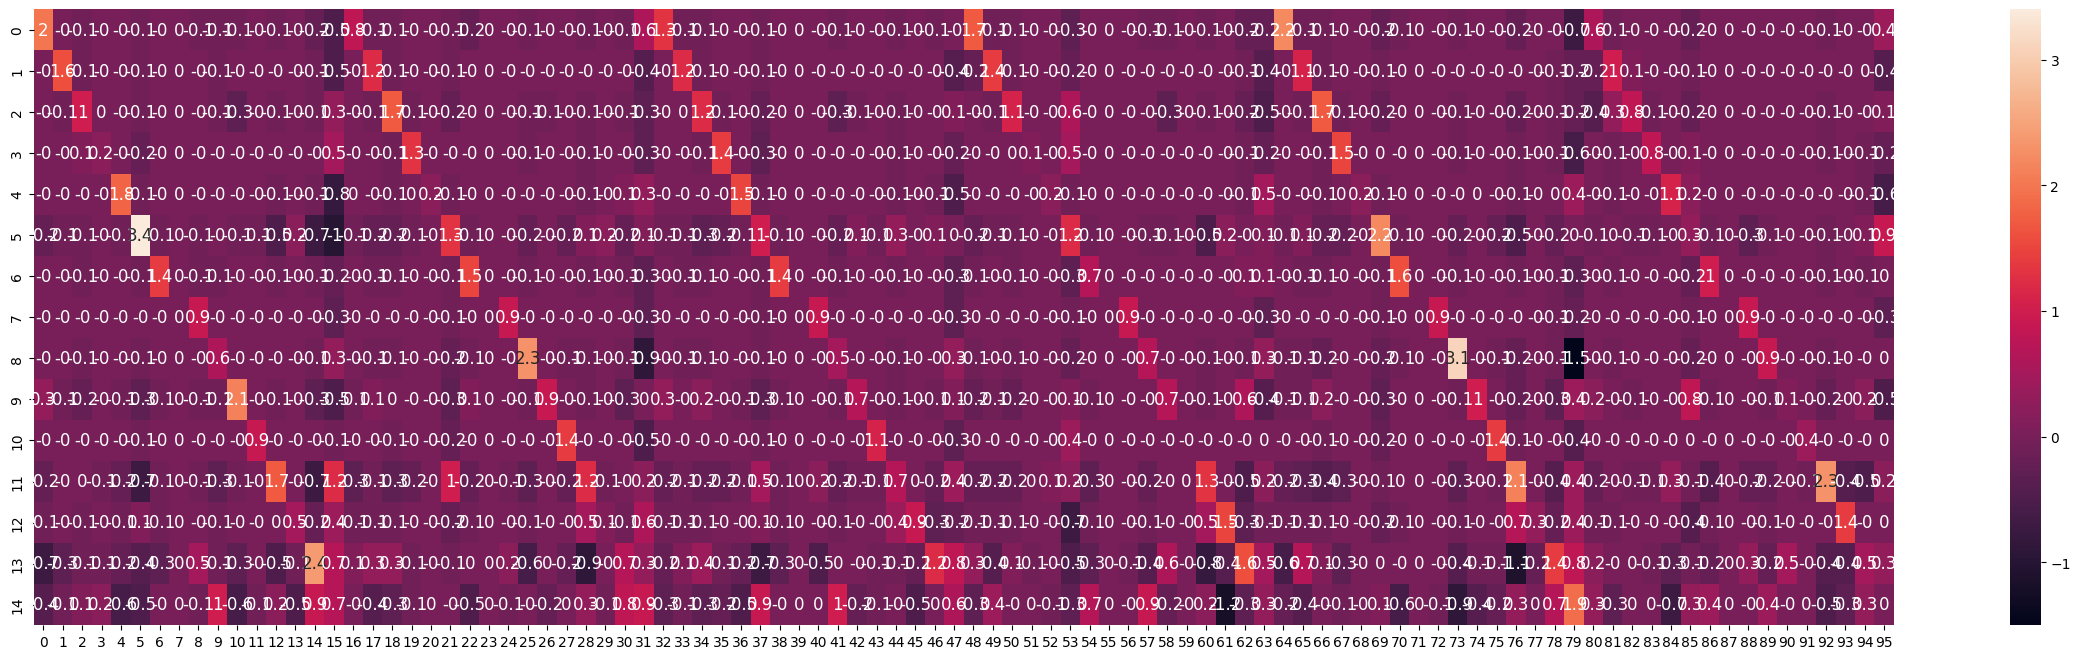

In [7]:
plt.figure(figsize=(30, 8))
sns.heatmap(
    (np.trunc(model.coef_ * 10) / 10),
    annot=True,
    annot_kws={"size": 12}
)

In [8]:
a = np.random.randint(0, 5,  size=[3,5])
b = np.random.randint(0, 5, size=[3, 5])

In [9]:
a, b

(array([[2, 4, 4, 3, 3],
        [3, 1, 4, 3, 3],
        [0, 3, 4, 3, 4]]),
 array([[3, 4, 4, 3, 2],
        [4, 1, 4, 3, 1],
        [2, 1, 0, 4, 4]]))

In [10]:
np.sum([a, b], axis=1)

array([[ 5,  8, 12,  9, 10],
       [ 9,  6,  8, 10,  7]])

In [11]:
days = sorted(
    [
        f.split("/")[-1].split("_")[-2]
        for f in glob(f"../data/2022/input/stacking_predictions/out/k3/darknet/test/features_*_fold00.csv")
    ]
)
days

['20221021',
 '20221022',
 '20221023',
 '20221024',
 '20221025',
 '20221026',
 '20221027',
 '20221028',
 '20221029',
 '20221030',
 '20221031']

In [12]:
def get_coeffs(case, target_source, strats_posfix, target_day):

    coeffs = []
    for fold in np.arange(10):
        model = load(
            f"../data/2022/output/{target_source}/{strats_posfix}/{case}/stacking_data/{target_day}/{fold}/lr.joblib"
        )
        coeffs.append(model.coef_)

    coeffs = np.sum(coeffs, axis=0)
    coeffs = coeffs / 10
    return coeffs, model


def format(probs_cols, stacking_strategies, sources):

    xl = []
    for source in sources:
        for strat in stacking_strategies:
            for c in probs_cols:
                xl.append(f"{source[0].upper()} / {strat} / {c}")

    return xl

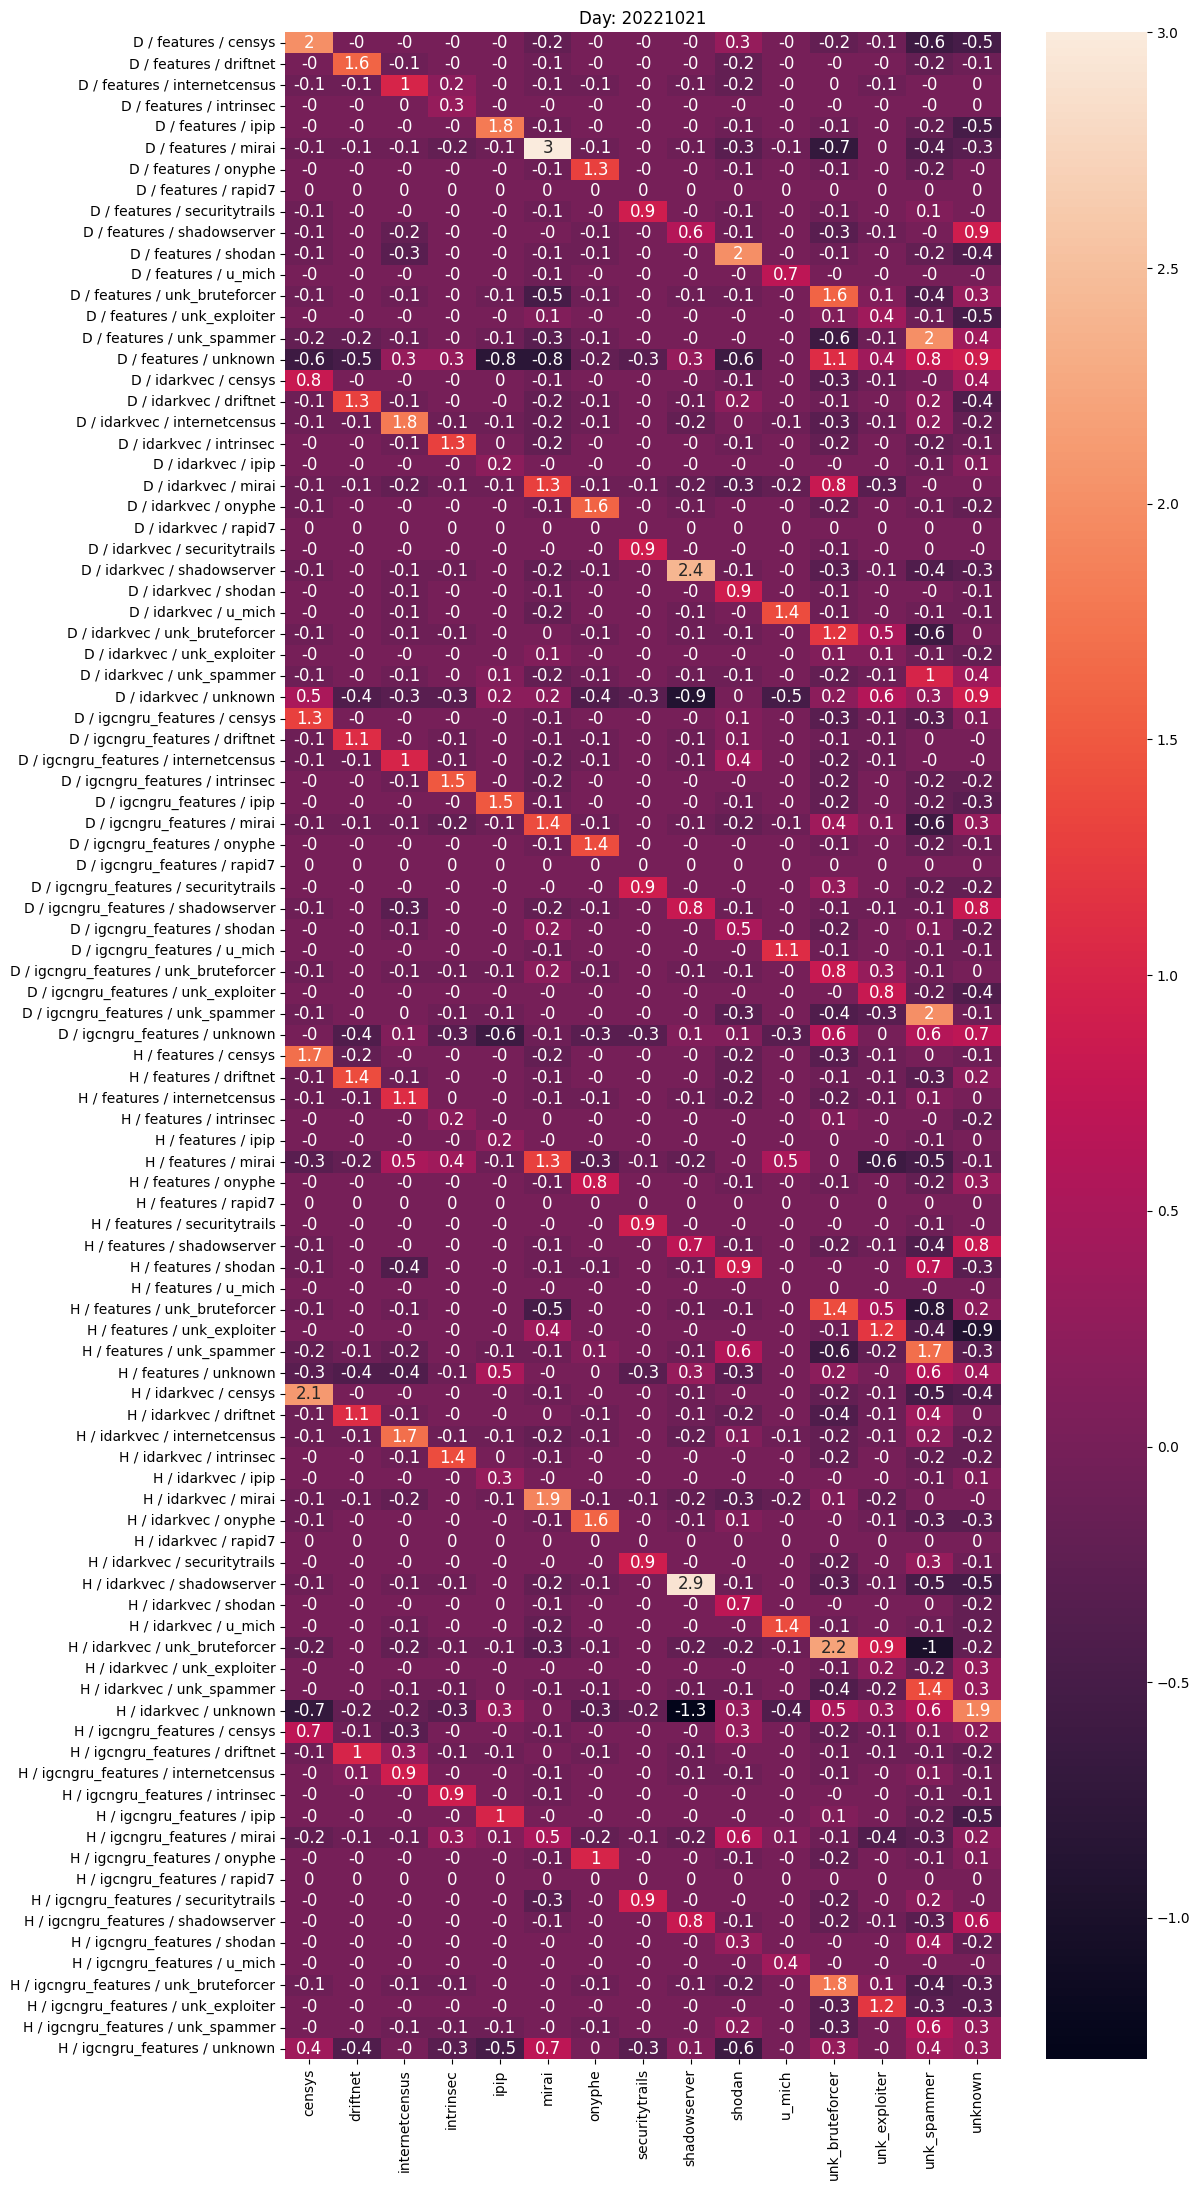

In [13]:
case = 1
coeffs, model = get_coeffs(case, '-'.join(SCENARIOS[1]["DATA_SOURCES"]), STRATS_POSFIX, target_day)
xl = format(probs_cols, stacking_strategies, SCENARIOS[1]["DATA_SOURCES"])
plt.figure(figsize=(12, 22))

sns.heatmap(
    (np.trunc(coeffs * 10) / 10).T,
    annot=True,
    annot_kws={"size": 12},
    yticklabels=xl,
    xticklabels=model.classes_,
)
plt.title(f"Day: 20221021")
plt.tight_layout()

In [14]:
for case in SCENARIOS:
    case_sources = SCENARIOS[case]["DATA_SOURCES"]
    source_sufix = '-'.join(case_sources)
    with PdfPages(f"../pdfs/charts/lrc/{source_sufix}_{case}.pdf") as pdf:
        for day in days:

            coeffs, model = get_coeffs(case, source_sufix, STRATS_POSFIX, day)
            xl = format(probs_cols, stacking_strategies, case_sources)
            height = 12 * len(case_sources)
            plt.figure(figsize=(12, height))

            sns.heatmap(
                (np.trunc(coeffs * 10) / 10).T,
                annot=True,
                annot_kws={"size": 12},
                yticklabels=xl,
                xticklabels=model.classes_,
            )
            plt.title(f"Day: {day}")
            plt.tight_layout()
            pdf.savefig(bbox_inches="tight")
            plt.close()
            print(day)


            out = {
                "coeffs": coeffs,
                "xlabels": xl,
                "ylabels": model.classes_
            }
            ddir = f"../data/logs/lrc/{case}/{day}"
            os.makedirs(ddir, exist_ok=True)
            save_pickle(out, f"{ddir}/lr.pkl")
            
            

20221021
20221022
20221023
20221024
20221025
20221026
20221027
20221028
20221029
20221030
20221031
20221021
20221022
20221023
20221024
20221025
20221026
20221027
20221028
20221029
20221030
20221031
20221021
20221022
20221023
20221024
20221025
20221026
20221027
20221028
20221029
20221030
20221031
20221021
20221022
20221023
20221024
20221025
20221026
20221027
20221028
20221029
20221030
20221031
20221021
20221022
20221023
20221024
20221025
20221026
20221027
20221028
20221029
20221030
20221031
